In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2024-05-12 16:08:44.199898: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 16:08:44.345044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 16:08:44.345291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 16:08:44.373425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-12 16:08:44.439057: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 16:08:44.440797: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
X_train, y_train = X_train_full[5000:], y_train_full[5000:]
X_val, y_val = X_train_full[:5000], y_train_full[:5000]

X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

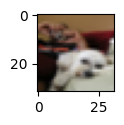

In [5]:
figure = plt.figure(figsize=(1,1))
plt.imshow(X_train[4])

In [6]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_sigma = inputs
        epsilon = keras.backend.random_normal(tf.shape(z_sigma))
        return z_mean + tf.math.exp(z_sigma / 2) * epsilon

In [7]:
INPUT_SHAPE = [32,32,3]
CODING_DIMS = 100

inputs = keras.layers.Input(shape=INPUT_SHAPE)
z = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="selu")(inputs)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.MaxPool2D(pool_size=2)(z)
z = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="selu")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.MaxPool2D(pool_size=2)(z)
z = keras.layers.Flatten()(z)
z = keras.layers.Dense(512, activation="selu")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Dense(256, activation="selu")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Dense(128, activation="selu")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Dense(CODING_DIMS, activation="relu")(z)
codings_mean = keras.layers.Dense(CODING_DIMS)(z)
codings_log_var = keras.layers.Dense(CODING_DIMS)(z)
codings = Sampling()([codings_mean, codings_log_var])

var_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

2024-05-12 16:08:53.382123: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 16:08:53.581294: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
decoder_inputs = keras.layers.Input(shape=[CODING_DIMS])
x = keras.layers.Dense(128, activation="selu")(decoder_inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="selu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="selu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(8*8*64, activation="selu")(x)
x = keras.layers.Reshape([8,8,64])(x)
x = keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation="selu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="selu")(x)
x = keras.layers.BatchNormalization()(x)
output = keras.layers.Conv2DTranspose(filters=3, kernel_size=3, padding="same", activation="sigmoid")(x)

var_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[output])

In [9]:
_, _, codings = var_encoder(inputs)
reconstructions = var_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

In [10]:
kl_divergence = -0.5 * keras.backend.sum(1 + codings_log_var - keras.backend.exp(codings_log_var) - keras.backend.square(codings_mean), axis=-1)

variational_ae.add_loss(keras.backend.mean(kl_divergence) / 3072.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=32,
                             validation_data=(X_val, X_val))

2024-05-12 16:08:55.928238: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


Epoch 1/25


2024-05-12 16:08:57.516731: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


1407/1407 [==============================] - 115s 80ms/step - loss: 0.6289 - rounded_accuracy: 0.7794 - val_loss: 0.6190 - val_rounded_accuracy: 0.7963
Epoch 2/25
1407/1407 [==============================] - 106s 76ms/step - loss: 0.6161 - rounded_accuracy: 0.8024 - val_loss: 0.6125 - val_rounded_accuracy: 0.8108
Epoch 3/25
1407/1407 [==============================] - 106s 76ms/step - loss: 0.6120 - rounded_accuracy: 0.8104 - val_loss: 0.6066 - val_rounded_accuracy: 0.8204
Epoch 4/25
1407/1407 [==============================] - 106s 76ms/step - loss: 0.6103 - rounded_accuracy: 0.8134 - val_loss: 0.6109 - val_rounded_accuracy: 0.8084
Epoch 5/25
1407/1407 [==============================] - 107s 76ms/step - loss: 0.6091 - rounded_accuracy: 0.8160 - val_loss: 0.6057 - val_rounded_accuracy: 0.8274
Epoch 6/25
1407/1407 [==============================] - 107s 76ms/step - loss: 0.6079 - rounded_accuracy: 0.8189 - val_loss: 0.6034 - val_rounded_accuracy: 0.8281
Epoch 7/25
1407/1407 [===========